# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
from scipy.interpolate import interp1d
import copy

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV  = 4*u.arcmin
los_reso = 30*u.kpc
los_size = 8*u.Mpc

# Analysis parameters
ps_mask_lim = 0.1*100 # mJy
mask_theta = 2*u.arcmin
Nsim = 1000
apply_radial_model = True

# Get the data

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
FoV_diameter = 2*u.arcmin
TF = libs.get_TF()

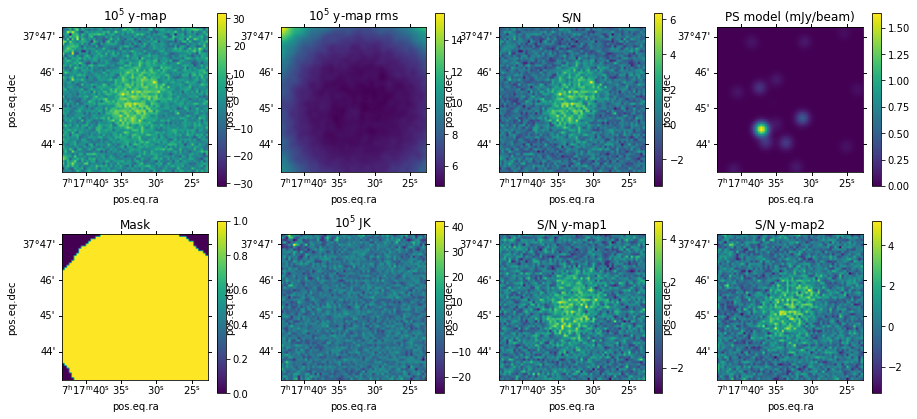

In [4]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 
                                                                                                     ps_mask_lim,
                                                                                                     show=True)

# Define the model, data and inference

In [5]:
#========== cluster data
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)

In [6]:
#========== cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param('A10MD')
cl_model.map_header = cl_head
cl_model.los_reso  = los_reso
cl_model.los_size  = los_size
cl_model.R_truncation = 10*u.Mpc

In [7]:
#========== Inference radial
cl_Rinfer1 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit1/')
cl_Rinfer2 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit2/')
cl_Rinfer3 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit3/')
cl_Rinfer4 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit4/')
cl_Rinfer5 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit5/')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radial Inference                        
------------------------------------------------------------
                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radi

# Fit the smooth model to the data

In [8]:
#========== Curvefit the profile case 1
RA  = cl_Rinfer1.model.coord.ra
Dec = cl_Rinfer1.model.coord.dec
fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer1.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 26.496225984047403 -0.8940625974611365 +0.8778086618505192
   best-fit = 26.430533376478067 -0.8283699898918009 +0.9435012694198548
   M500 = 26.496225984047403_{-0.8940625974611365}^{0.8778086618505192}
param 1 (RA): 
   median   = 109.38689343775687 -0.0003623196476638668 +0.0003575983038786035
   best-fit = 109.3865186939409 --1.2424168303937222e-05 +0.0007323421198464075
   RA = 109.38689343775687_{-0.0003623196476638668}^{0.0003575983038786035}
param 2 (Dec): 
   median   = 37.75299338921657 -0.00034845341986056155 +0.00034755641238604085
   best-fit = 37.7527086196303 -6.368383358790197e-05 +0.0006323259986587004
   Dec = 37.75299338921657_{-0.00034845341986056155}^{0.00034755641238604085}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.7813713606729675 -0.025947134373471625 +0.026734572223987563
   best-fit = 0.7806226249277687 -0.025198398628272778 +0.02748330796918641
   min_to_maj_axis_ratio = 0.7813713606729675_{-0.025947134373471625}^{0.0267

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [9]:
#========== Curvefit the profile case 2
fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'ZL':{'guess':[0,1e-5],'unit':None},
}
plist, popt, pcov = cl_Rinfer2.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 18.138964469655356 -0.4975813322864795 +0.5015804806327395
   best-fit = 18.14228039737663 -0.5008972600077541 +0.4982645529114649
   M500 = 18.138964469655356_{-0.4975813322864795}^{0.5015804806327395}
param 1 (ZL): 
   median   = 1.828376844827982e-05 -9.79251382789573e-07 +9.814892097353635e-07
   best-fit = 1.833270131436883e-05 -1.0281842488785826e-06 +9.325563436463538e-07
   ZL = 1.828376844827982e-05_{-9.79251382789573e-07}^{9.814892097353635e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [10]:
#========== Curvefit the profile case 3
RA  = cl_Rinfer3.model.coord.ra
Dec = cl_Rinfer3.model.coord.dec

fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer3.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 21.67120688855097 -0.522677738859521 +0.5253249400833049
   best-fit = 21.670280982007245 -0.5217518323157968 +0.526250846627029
   M500 = 21.67120688855097_{-0.522677738859521}^{0.5253249400833049}
param 1 (RA): 
   median   = 109.38705153064372 -0.0003950514799555549 +0.00038616972537397487
   best-fit = 109.3870653659626 -0.0004088867988372158 +0.000372334406492314
   RA = 109.38705153064372_{-0.0003950514799555549}^{0.00038616972537397487}
param 2 (Dec): 
   median   = 37.75297858797236 -0.00031441456095393505 +0.0003099540303068693
   best-fit = 37.752590823474954 --7.334993645002896e-05 +0.0006977185277108333
   Dec = 37.75297858797236_{-0.00031441456095393505}^{0.0003099540303068693}
param 3 (ZL): 
   median   = 1.586715357814496e-05 -9.981601757016271e-07 +1.0066633625085771e-06
   best-fit = 1.7464738658803483e-05 -2.5957452563601485e-06 +-5.909217181499442e-07
   ZL = 1.586715357814496e-05_{-9.981601757016271e-07}^{1.0066633625085771e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [11]:
#========== Curvefit the profile
RA  = cl_Rinfer4.model.coord.ra
Dec = cl_Rinfer4.model.coord.dec

fitpar_prof = {
'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer4.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.11700896289490179 -0.00789838726523387 +0.007901223825415415
   best-fit = 0.1131416778484689 -0.004031102218800986 +0.011768508871848299
   P_0 = 0.11700896289490179_{-0.00789838726523387}^{0.007901223825415415}
param 1 (r_p): 
   median   = 852.4962834271173 -43.428631218482224 +43.6761548788254
   best-fit = 852.2587681615345 -43.191115952899395 +43.91367014440823
   r_p = 852.4962834271173_{-43.428631218482224}^{43.6761548788254}
param 2 (RA): 
   median   = 109.38731359870982 -0.0002768720773218547 +0.00028191128001253674
   best-fit = 109.38750002319048 -0.0004632965579816073 +9.548679935278415e-05
   RA = 109.38731359870982_{-0.0002768720773218547}^{0.00028191128001253674}
param 3 (Dec): 
   median   = 37.752925926891976 -0.00027617849522698634 +0.0002826897476211343
   best-fit = 37.75244330060541 --0.00020644779134215696 +0.0007653160341902776
   Dec = 37.752925926891976_{-0.00027617849522698634}^{0.0002826897476211343}
param 4 (min_to_maj_axis_

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [12]:
#========== Curvefit the profile
RA  = cl_Rinfer5.model.coord.ra
Dec = cl_Rinfer5.model.coord.dec

fitpar_prof = {
'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
'b': {'guess':[5, 0.5], 'unit': None, 'limit':[2, 8]},
'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[0, 2]},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer5.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.10120852328714094 -0.012156855554692925 +0.009683761901698187
   best-fit = 0.1050431841307749 -0.015991516398326883 +0.005849101058064229
   P_0 = 0.10120852328714094_{-0.012156855554692925}^{0.009683761901698187}
param 1 (r_p): 
   median   = 428.26429905008865 -35.584377825369586 +28.310889373322766
   best-fit = 463.5168611692178 -70.83693994449874 +-6.941672745806386
   r_p = 428.26429905008865_{-35.584377825369586}^{28.310889373322766}
param 2 (a): 
   median   = 8.55118473090976 -1.3952185161340012 +1.0040935613170472
   best-fit = 6.376337509735419 --0.7796287050403405 +3.178940782491389
   a = 8.55118473090976_{-1.3952185161340012}^{1.0040935613170472}
param 3 (b): 
   median   = 6.176506773224554 -1.833659852411845 +1.2565084552107617
   best-fit = 7.388440998070727 -3.0455940772580172 +0.04457423036458952
   b = 6.176506773224554_{-1.833659852411845}^{1.2565084552107617}
param 4 (c): 
   median   = 0.12171179513619995 -0.08522297190728803 +0.1

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


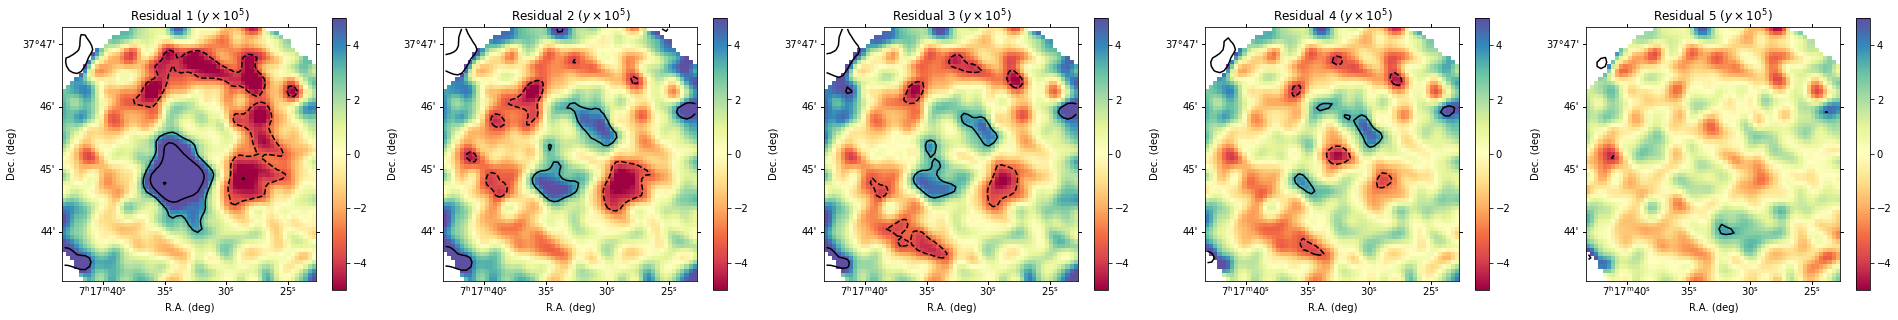

In [13]:
#===== Show the images

smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(33, 5))
model_sph1 = cl_Rinfer1.get_radial_model()
model_sph2 = cl_Rinfer2.get_radial_model()
model_sph3 = cl_Rinfer3.get_radial_model()
model_sph4 = cl_Rinfer4.get_radial_model()
model_sph5 = cl_Rinfer5.get_radial_model()
    
rms = cl_data.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])
    
rng = [-5,5]

msk = copy.deepcopy(cl_data.mask)
msk[cl_data.mask == 0] = np.nan
    
#----- Residual 1
ax = plt.subplot(1, 5, 1, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph2, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph2, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 1 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Cluster model
ax = plt.subplot(1, 5, 2, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph3, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph3, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 2 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 3, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph1, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph1, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 3 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 4, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph4, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph4, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 4 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 5, 5, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph5, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph5, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 5 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

plt.savefig(outdir+'/RadialFit_residuals.pdf')